In [ ]:
# DS776 Auto-Update (runs in ~2 seconds, only updates when needed)
# If this cell fails, see Lessons/Course_Tools/AUTO_UPDATE_SYSTEM.md for help
%run ../Course_Tools/auto_update_introdl.py

# Transformer Encoder Learns Math

In this notebook we'll teach a simple tranformer encoder to predict the signs of sums specified as sequences of strings.

For example "plus four minus seven minus three" which represents the "+4+7-3" would be labeled as positive and "minus five plus seven minus eight" would be labeled as non-positive.  We don't label it as "negative" because we're going to count zero as non-positive to give us a binary classification problem.

We'll generate thousands of samples for training.  What's remarkable is that a transformer encoder model with single-head attention and two transformer layers can learn to classify these sums with nearly 100% accuracy without having any knowledge of the underlying math.  

Moreover the simplicity of this example allows us to build the model from scratch and to be able to inspect the attention weights to see how transformer is "thinking."  

## Imports

In [1]:
# imports and configuration

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from viz_functions import visualize_positional_encodings, display_attention
from viz_functions import plot_attention_weights, plot_attention_weights_widget

from introdl.utils import get_device, load_results, load_model, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

✅ Environment: Unknown Environment | Course root: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776
   Using workspace: <DS776_ROOT_DIR>/home_workspace

📂 Storage Configuration:
   DATA_PATH: <DS776_ROOT_DIR>/home_workspace/data
   MODELS_PATH: <DS776_ROOT_DIR>/Lessons/Lesson_09_Transformer_Details/Lesson_09_Models (local to this notebook)
   CACHE_PATH: <DS776_ROOT_DIR>/home_workspace/downloads
📦 introdl v1.4.1 ready



## Data Generation and DataLoaders

We're going to generate sequences like 'plus seven plus three minus five plus one minus two plus six' and labels that represent whether the mathematical sum of the sequence is positive.  We'll assign a label of "1" for a sum > 0, and a label of "0" for a sum <= 0.  Each sequence can contain from 1 to 20 numbers.

#### L09_1_The_Dataset Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_the_dataset/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_the_dataset/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/nslMrf6MIOT" target="_blank">Open Descript version of video in new tab</a>


In [2]:
class ArithmeticSequenceDataset(Dataset):
    """
    A PyTorch Dataset class for generating and handling arithmetic sequences.
    Attributes:
        num_samples (int): The number of samples in the dataset.
        max_length (int): The maximum number of digits in each sequence.
        num_map (dict): A dictionary mapping number words to their integer values.
        total_positive (int): The total number of sequences with a positive sum.
        correct_dominant_sign (int): The number of sequences where the dominant sign matches the label.
        data (list): A list of generated arithmetic sequences.
        labels (list): A list of labels corresponding to the sequences.
    Methods:
        __init__(num_samples, max_length=20, seed=None):
            Initializes the dataset with the given number of samples and maximum sequence length.
        generate_dataset(num_samples, max_length):
            Generates a dataset of arithmetic sequences and their corresponding labels.
        __len__():
            Returns the number of samples in the dataset.
        __getitem__(idx):
            Returns the sequence and label at the specified index.
    """

    def __init__(self, num_samples, max_length=20, seed=None):
        np.random.seed(seed)
        self.num_samples = num_samples
        self.max_length = max_length
        self.num_map = {
            "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
            "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
        }
        self.total_positive = 0
        self.correct_dominant_sign = 0
        self.data, self.labels = self.generate_dataset(num_samples, max_length)

    def generate_dataset(self, num_samples, max_length):
        operators = ["plus", "minus"]
        digits = list(self.num_map.keys())  # Including "zero"
        sequences = []
        labels = []
        unique_sequences = set()

        while len(sequences) < num_samples:
            # Generate a random sequence
            length = np.random.randint(1, max_length + 1)
            numbers = np.random.choice(digits, length, replace=True)
            ops = np.random.choice(operators, length, replace=True)
            sequence = " ".join([f"{op} {num}" for op, num in zip(ops, numbers)])
            
            # Ensure uniqueness
            if sequence in unique_sequences:
                continue  # Skip and regenerate if not unique

            unique_sequences.add(sequence)

            # Calculate the sum
            sum_numbers = np.sum([
                self.num_map[num] if op == "plus" else -self.num_map[num] 
                for op, num in zip(ops, numbers)
            ])
            label = int(sum_numbers > 0)  # Return integers 0 or 1
            self.total_positive += label

            # Track dominant sign correctness
            plus_count = sum(ops=="plus")
            minus_count = sum(ops=="minus")
            dominant_sign = 1 if plus_count > minus_count else 0
            if dominant_sign == label:
                self.correct_dominant_sign += 1

            # Store the sequence and label
            sequences.append(sequence)
            labels.append(label)
        
        return sequences, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [3]:
num_samples = 20000
dataset = ArithmeticSequenceDataset(num_samples, 10, seed=42)
torch.manual_seed(42)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Let's see a few examples:

In [4]:
for i in range(3):
    print(valid_dataset[i])

('plus seven plus three minus five plus one minus two plus six', 1)
('plus four plus eight minus zero plus four plus six minus four', 1)
('minus six plus seven minus four', 0)


## Tokenization

#### L09_1_Tokenization Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_tokenization/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_tokenization/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/9Ks93yP0F6W" target="_blank">Open Descript version of video in new tab</a>

To use these sequences to train a transformer model we need to add some special tokens: "&lt;CLS&gt;" and "&lt;PAD&gt;".  The "&lt;CLS&gt;", or classifier, token will be prepended to each sequence.  The transformed output corresponding to the "&lt;CLS&gt;" token is what is passed to the final classification layer of our model.  The "&lt;PAD&gt;" token is used to add padding to the sequences in each batch to make all sequences the same length as the longest sequence in the batch.  This is needed so that the model can process sequences in parallel.  We instruct the model to ignore the "&lt;PAD&gt;" tokens in its computations.

In [5]:
# <PAD> token must be 0 in our vocabulary 
vocab = {
    "<PAD>": 0, "<CLS>": 1, "plus": 2, "minus": 3,
    "zero": 4, "one": 5, "two": 6, "three": 7, "four": 8,
    "five": 9, "six": 10, "seven": 11, "eight": 12, "nine": 13
}

# custom collate function
def pad_batch(batch):
    """
    Pads a batch of sequences to the same length and converts them to tensor format.
    Args:
        batch (list of tuples): A list of tuples where each tuple contains a sequence (str) and a label (int).
    Returns:
        tuple: A tuple containing:
            - torch.Tensor: A tensor of padded sequences with shape (batch_size, max_length + 1).
            - torch.Tensor: A tensor of labels with shape (batch_size,).
    Note:
        - Each sequence is tokenized by splitting on whitespace.
        - A special token '<CLS>' is added at the beginning of each sequence.
        - Sequences are padded with the '<PAD>' token to match the length of the longest sequence in the batch.
        - The `vocab` dictionary is used to convert tokens to their corresponding indices.
    """

    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = ['<CLS>'] + seq.split()
        padded = [vocab[token] for token in tokens] + [vocab["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch)

Let's use `pad_batch` to tokenize and pad the first three sequences from the validation set.  Here are those sequences again:

In [6]:
for i in range(3):
    print(valid_dataset[i])

('plus seven plus three minus five plus one minus two plus six', 1)
('plus four plus eight minus zero plus four plus six minus four', 1)
('minus six plus seven minus four', 0)


Now here they are after tokenization and padding:

In [7]:
small_batch = [valid_dataset[i] for i in range(3)]
padded_batch = pad_batch(small_batch)
padded_batch


(tensor([[ 1,  2, 11,  2,  7,  3,  9,  2,  5,  3,  6,  2, 10],
         [ 1,  2,  8,  2, 12,  3,  4,  2,  8,  2, 10,  3,  8],
         [ 1,  3, 10,  2, 11,  3,  8,  0,  0,  0,  0,  0,  0]]),
 tensor([1, 1, 0]))

Notice that each tokenized sequence begins with 1 which is the numerical value of the "&lt;CLS&gt;" token.   The next token is a 2 or 3 for "plus" and "minus", repsectively.  The numbers 4-13 represent the digits 0 through 9.   Note that the last sequence is shorter so gets padded with 0 tokens which will be ignored by our models.

## Embeddings

#### L09_1_Embeddings Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_embeddings/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_embeddings/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/2kQfyzbVYL9" target="_blank">Open Descript version of video in new tab</a>

In any transformer architecture the numerical tokens are converted into vectors called embeddings at the beginning of the model.  The values in these vectors are learned through the model training.  We have to choose how long each embedding vector will be.  That length is called the embedding_dimnension.  Learnable embeddings are easy to create in Pytorch.

Here we create an embedding layer that maps sequences from a vocabulary of size 14 to vectors of length 16.  

In [8]:
embed_dim = 16
vocab_size = len(vocab) # 14
embedding_layer = nn.Embedding(vocab_size, embed_dim)
embeddings = embedding_layer(padded_batch[0])
embeddings.shape

torch.Size([3, 13, 16])

We can inspect the embedding of the first sequence in our small batch.  This is the representation of '&lt;CLS&gt; plus seven plus three minus five plus one minus two plus six' before it goes through the transformer layers.

In [9]:
embeddings[0,:,:]

tensor([[ 0.8369, -0.8633, -1.5713,  0.5664,  0.0865,  0.8255,  0.3623, -1.1215,
          0.3635, -0.1056,  0.9589,  0.8936,  0.8743, -1.7092, -0.2742, -0.8631],
        [-0.9093, -0.7726,  0.3469, -0.3571, -0.6095,  0.3605, -0.8189,  1.0898,
         -1.2832,  1.5626, -0.9732,  1.0730, -2.0888, -1.7766,  0.2693,  0.8466],
        [ 0.4739,  0.2438, -0.9863,  0.2487, -1.1114,  1.3589,  1.9481,  0.8827,
          0.3252,  1.9964, -0.9571, -0.4201, -0.1126, -0.4846,  2.7983,  0.0166],
        [-0.9093, -0.7726,  0.3469, -0.3571, -0.6095,  0.3605, -0.8189,  1.0898,
         -1.2832,  1.5626, -0.9732,  1.0730, -2.0888, -1.7766,  0.2693,  0.8466],
        [-0.8076,  1.1369, -0.1228, -0.5656,  0.5939, -0.5811,  0.1357,  0.2790,
          0.2493,  0.7065,  0.3244, -0.9336,  0.4035,  1.8694, -0.6093, -0.2967],
        [-0.1857, -0.8620,  0.3571,  2.0496,  0.7243, -0.8240,  0.4119,  0.8887,
          0.3870,  0.6372, -1.6996,  1.3361,  1.6373,  0.9134,  1.0054,  0.9127],
        [ 0.5818,  1.1

It doesn't look like much.  There are 13 vectors of length 16.  The way embeddings work is that the embedding vector for any particular token, e.g. "&lt;CLS&gt;", always maps to the same embedding vector.  The embedding vectors themselves are randomly initialized when the model is instantiated.  During training the embedding vectors are updated until they best represent the information needed for the task at hand.

## Positional Encoding

#### L09_1_Positional_Encodings Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_positional_encodings/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_positional_encodings/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/nMLBBgM7M5U" target="_blank">Open Descript version of video in new tab</a>


A transformer by itself processes each token a sequence in exactly the same way.  The transformer isn't aware of the position of each token in the sequence.  This is why positional encoding is used in most transformers.  After each token is converted to an embedding vector, a vector unique to the each position is added to the embedding vector.  The only requirement is that the position vector for each position is unique.  We'll use sinusoidal positional encoding as was done in the original transformer paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762), but alternatives include relative positional encoding and learned (trainable) positional encodings.

If you want to learn more about positional encoding there are many videos on YouTube.  For example, the video ["How positional encoding works in transformers"](https://www.youtube.com/watch?v=T3OT8kqoqjc&ab_channel=BrainDrain) is less than 6 minutes and gives an idea of what is going on though it won't be enough to understand the gritty details.  Don't dive deeply into the details unless you plan on doing research with transformers.

The code in the next cell defines a class called PositionalEncoding that builds an object for creating positional encoding vectors with a desired embedding dimension for sequences up to a maximum length.  The details of this code aren't important for now.

In [10]:
class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to input embeddings to incorporate positional information.
    """

    def __init__(self, d_model, max_len=500):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): Dimensionality of the embedding space.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for adding positional encoding.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Input tensor with positional encoding added.
        """
        return x + self.pe[:, :x.size(1)]

Now, as an example, we'll create positional encoding vectors of length 16 for sequences of length up to 40.  Each vector is displayed as a row in the graph below.  The main thing to understand is that each vector is unique so that the transformer can learn positional information during training.

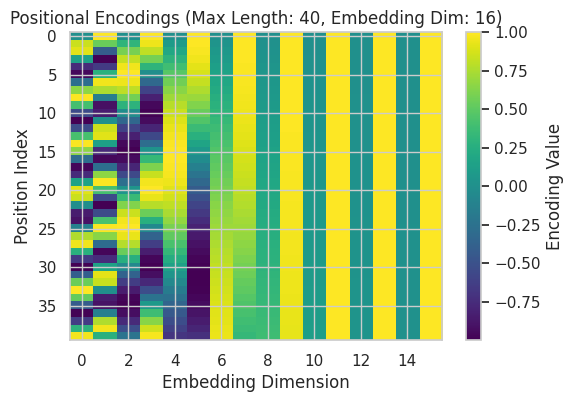

In [11]:
# Create a PositionalEncoding instance and visualize
embed_dim = 16
max_len = 40
pos_encoder = PositionalEncoding(embed_dim, max_len=max_len)
visualize_positional_encodings(pos_encoder, max_len=max_len, d_model=embed_dim, figsize=(6, 4))


Now we're ready to see the basics of a transformer encoder model. 

## Transformer Encoder - Building Blocks

We'll discuss the pictures below in a short video.  

#### L09_1_Transformer_Layers Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_transformer_layers/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_transformer_layers/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/gyTRUJ8E9t0" target="_blank">Open Descript version of video in new tab</a>


<img src="./pictures/TransformerLayer.png" alt="Transformer Layer" width=1000>


The next picture comes from the book [Understanding Deep Learning](https://udlbook.github.io/udlbook/) which is a great book if you want to really understand the mathematical details of transformer models.  The pdf version of the book is free to download.

<img src="./pictures/TransformerEncoder.png" alt="Transformer Encoder" width=1000>

## The Self-Attention Layer

#### L09_1_Self_Attention Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_self_attention/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_self_attention/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/3MI1BJeD88j" target="_blank">Open Descript version of video in new tab</a>


Self-attention is what gives transformers the ability to understand context.  A self-attention layer learns from examples what other tokens each token in a sequence should "attend" to or "pay attention" to in order to establish their meaning.  For example we'll see below that for the sequence 'plus seven plus three minus five plus one minus two plus six' the embedding of each number has to pay attention to the embedding of the 'plus' or 'minus' just before it to establish the meaning of that number in the sequence.

If you've read about the attention mechanism in the book or elsewhere you've probably seen the terms query, key, and value in that context.  I find it helpful to understand where those terms come from to navigate those readings:

### Queries, Keys, Values, and all that ...

These names are inspired by the way data retrieval systems work, such as in databases:

- **Queries**: These are like search queries in a database. In the context of attention mechanisms, a query is what you are currently looking at or processing, and you want to find out how much relevance or importance other data points have in relation to this query. For tranformers: *Queries represent the current element (e.g., word or token) in the sequence for which the attention mechanism is trying to compute an output.*

- **Keys**: In databases, keys are used to index and retrieve data quickly. In transformers, keys are used to match against the queries. The ability of a key to respond to a query determines how much attention (or computational focus) is given to the corresponding data point (value). For transformers *Keys correspond to all elements in the sequence, against which the query is compared.*

- **Values**: These are the actual data stored in the database that you retrieve using the keys. In transformers, values are the pieces of information that are weighted according to the attention determined by the query-key matching and then aggregated to form the output.  For transfomers: *Values are encoded versions of the elements in the sequence.*

Now that you're armed with that knowledge let's look the self-attention mechanism in a bit more detail. Here's a short video discussing the self-attention mechanism as depicted below:

<img src="./pictures/SelfAttention.png" alt="Self-Attention Layer" width=900>

Sometimes, this kind of self-attention is called bidirectional because each output word embedding attends to other embeddings before and after it in the input sequence.  This kind of attention is used in transformer encoder architectures which includes those used for text classification, named entitiy recognition, and vision transformers like you saw briefly in the lesson on tranfer learning.  Transformer encoders are also the first half of "sequence to sequence" tranformers that are used in translation and summarization tasks.  In a sequence to sequence transformer the encoder is paired with a decoder transformer.  We'll talk briefly about decoders at the end of this lesson.

If you find yourself wanting more details about the self attention calculations I think the video at this site does a great job - https://newsletter.theaiedge.io/p/understanding-the-self-attention.


## Putting it altogether - A Single Head Tranformer Encoder from Scratch

PyTorch has ready made classes for transformers, but we'll implement our own here so see the pieces and how they fit together.  We'll use only single-head attention to keep things simple.  Using our own implementation also makes it simpler to extract the attention weights for inspection after training.

Watch the video below to get more details about the code.

#### L09_1_Transformer_Encoder Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_transformer_encoder/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_transformer_encoder/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/Q1Kn21m5RYW" target="_blank">Open Descript version of video in new tab</a>


In [12]:
class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to input embeddings to incorporate positional information.
    """

    def __init__(self, d_model, max_len=500):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): Dimensionality of the embedding space.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for adding positional encoding.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Input tensor with positional encoding added.
        """
        return x + self.pe[:, :x.size(1)]

class SingleHeadAttention(nn.Module):
    """
    Implements single-head attention for transformer models.
    """

    def __init__(self, embed_dim):
        """
        Initializes the SingleHeadAttention module.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
        """
        super(SingleHeadAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = math.sqrt(embed_dim)
        self.attention_weights = None

    def forward(self, x, mask=None):
        """
        Forward pass for single-head attention.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).
            mask (torch.Tensor): Mask tensor of shape (batch_size, seq_length, seq_length).

        Returns:
            torch.Tensor: Output tensor after applying attention.
        """
        Q = self.query(x)  # Shape: (batch_size, seq_length, embed_dim)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # Shape: (batch_size, seq_length, seq_length)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        self.attention_weights = F.softmax(attention_scores, dim=-1)  # Shape: (batch_size, seq_length, seq_length)
        return torch.matmul(self.attention_weights, V)  # Shape: (batch_size, seq_length, embed_dim)

class TransformerLayer(nn.Module):
    """
    A single transformer layer comprising attention, residual connections,
    layer normalization, and a feedforward network.
    """

    def __init__(self, embed_dim, hidden_dim):
        """
        Initializes the TransformerLayer.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
        """
        super(TransformerLayer, self).__init__()
        self.attention = SingleHeadAttention(embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        """
        Forward pass for the transformer layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).
            mask (torch.Tensor): Mask tensor of shape (batch_size, seq_length, seq_length).

        Returns:
            torch.Tensor: Output tensor after applying attention and feedforward network.
        """
        attn_output = self.attention(x, mask)  # Shape: (batch_size, seq_length, embed_dim)
        x = self.norm1(x + attn_output)
        x2 = self.mlp(x)  # Shape: (batch_size, seq_length, embed_dim)
        return self.norm2(x + x2)

    def get_attention_weights(self):
        """
        Retrieves attention weights.

        Returns:
            torch.Tensor: Attention weights from the SingleHeadAttention module.
        """
        return self.attention.attention_weights

class SingleHeadTransformerEncoder(nn.Module):
    """
    Transformer encoder with single-head attention.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers):
        """
        Initializes the SingleHeadTransformerEncoder.

        Args:
            vocab_size (int): Vocabulary size.
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
            num_classes (int): Number of output classes.
            num_layers (int): Number of transformer layers.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(embed_dim, hidden_dim) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        """
        Forward pass for the transformer encoder.

        Args:
            x (torch.Tensor): Input tensor of token indices.

        Returns:
            torch.Tensor: Output logits for classification.
        """
        mask = (x != 0).unsqueeze(1).expand(-1, x.size(1), -1)  # Shape: (batch_size, seq_length, seq_length)
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        x = self.pos_encoder(x)
        for layer in self.transformer_layers:
            x = layer(x, mask)
        cls_token = x[:, 0, :]  # Shape: (batch_size, embed_dim)
        logits = self.classifier(cls_token)  # Shape: (batch_size, num_classes)
        return logits

    def get_attention_weights(self):
        """
        Retrieves attention weights from all transformer layers.

        Returns:
            list: List of attention weight tensors, one for each layer.
        """
        return [layer.get_attention_weights() for layer in self.transformer_layers]


## Train a Model with a Single Transformer Layer

Here we'll train our Transformer Encoder with a single transformer layer. Afterward we'll evaluate its performance and visualize the attention weights to see if we can understand what it has learned.

#### L09_1_Single_Layer_Encoder Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_single_layer_encoder/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_single_layer_encoder/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/fPEsDTJMbPQ" target="_blank">Open Descript version of video in new tab</a>

In [13]:
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, num_classes=2, num_layers=1)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.003)  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)
model=model.to(device)

ckpt_file = MODELS_PATH / 'L09_math_transformer_one_layer.pt'
epochs = 20

score_funcs = {'ACC':accuracy_score}

cuda


In [14]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_metric='ACC',
                        early_stop_crit='max',
                        patience=5)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping at epoch 16


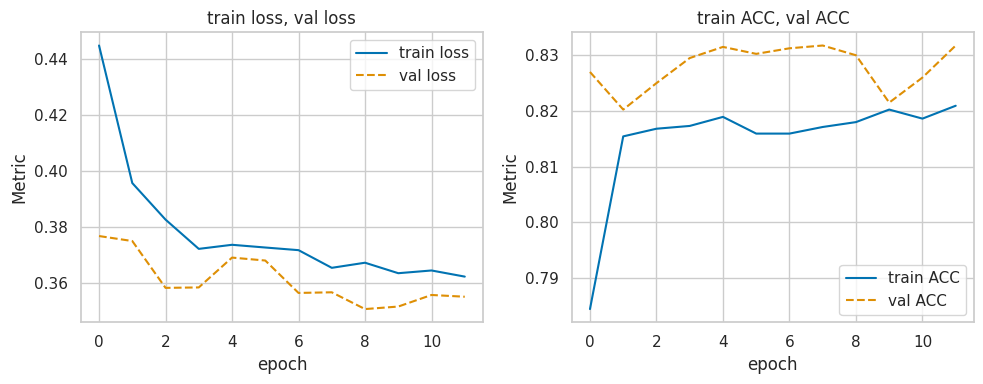

In [15]:
results = load_results(MODELS_PATH / 'L09_math_transformer_one_layer.pt')
plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

After the first epoch, the model achieves about 82% classification accuracy and never doesn't improve further.  Not coincidentally that is the percentage of sequences in the dataset where we can predict the class as positive if there are more "plus" signs than "minus" signs.  During the construction of the dataset we counted those sequences and stored them as an attribute.

In [16]:
print("Percentage of sequences correctly predicted by dominant sign:", 
      100*dataset.correct_dominant_sign/len(dataset) )

Percentage of sequences correctly predicted by dominant sign: 82.33


In [17]:
# reload the model
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, num_classes=2, num_layers=1)
model = load_model(model, MODELS_PATH / 'L09_math_transformer_one_layer.pt', device=get_device())

In [18]:
plot_attention_weights_widget(model, valid_loader, vocab)

Output()

In [19]:
display_attention(0, model, valid_loader, vocab)

<IPython.core.display.Javascript object>

## Train a Model with Two Transformer Layers

By adding a second transformer layer, the model can achieve up to 100% accuracy on the test data!  The first attention layer seems to aggregate the values of the digits and the signs while the second attention layer seems to add the signed values to get the "<CLS>" token.

#### L09_1_Two_Layer_Encoder Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_two_layer_encoder/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l09_1_two_layer_encoder/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/TWS9kVw2Bjg" target="_blank">Open Descript version of video in new tab</a>


In [20]:
model = SingleHeadTransformerEncoder(vocab_size=14, 
                                     embed_dim=16, 
                                     hidden_dim=64, 
                                     num_classes=2, 
                                     num_layers=2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.003)  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)
model=model.to(device)

ckpt_file = MODELS_PATH / 'L09_math_transformer_two_layers.pt'
epochs = 150

score_funcs = {'ACC':accuracy_score}

cuda


In [21]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_metric='ACC',
                        early_stop_crit='max',
                        patience=20)

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Early stopping at epoch 75


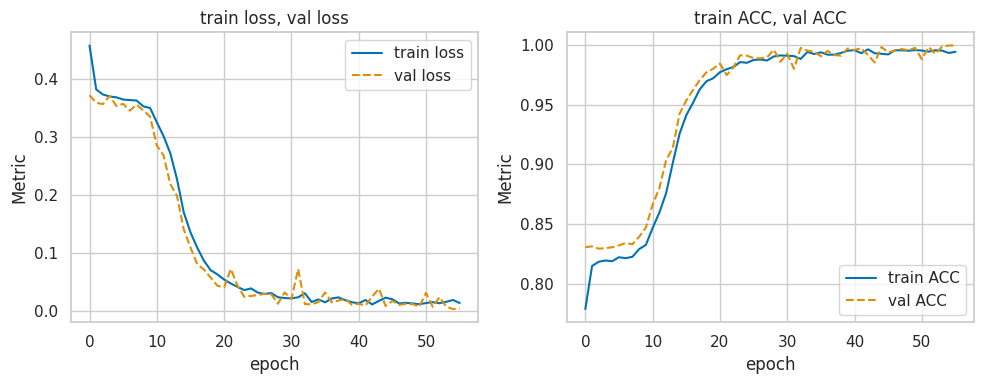

In [22]:
results = load_results(MODELS_PATH / 'L09_math_transformer_two_layers.pt')
plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [23]:
results.tail()

,epoch,total time,train loss,val loss,train ACC,val ACC
51,51,142.132803,0.014547,0.006441,0.994375,0.99825
52,52,143.200877,0.012731,0.023176,0.995500,0.99250
53,53,144.308978,0.015059,0.006720,0.995250,0.99850
54,54,145.564969,0.018322,0.002617,0.993250,0.99950
55,55,146.697770,0.013097,0.003341,0.994250,0.99950


In [24]:
# reload the model
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, 
                                     num_classes=2, num_layers=2)
model = load_model(model, MODELS_PATH / 'L09_math_transformer_two_layers.pt', device=get_device())

In [25]:
plot_attention_weights_widget(model, valid_loader, vocab)

Output()

In [26]:
display_attention(0, model, valid_loader, vocab)

<IPython.core.display.Javascript object>

## Decoder Architectures

The building blocks of a transformer decoder model are nearly identical to those of an encoder.  The only significant difference is that the self-attention matrix is modified so the each output embedding can only attend to input embeddings that come before it in the sequence.  This is because decoders, used for chatbots, are usually used in auto-regressive fashion.  Auto-regression means that the incomplete text is fed to the model so that it can predict the next token in the sequence.  This token is appended to the sequence and the whole thing is fed to the model again, repeatedly.  So a decoder model has to figure out the relationships between each token and the previous tokens.


Sequence-to-sequence transfomers, like those use in translation and summarization, use an encoder followed by a decoder.  The token embeddings produced the encoder are used as the keys in a "cross-attention" mechanism in the decoder.  Imagine a translation task where the encoder figures out the relationships between words and meanings of words in the source language, then the sequence in the target language is decoded one token at a time by combining the embeddings produced from the source language with its knowledge of the target language.

If you want to learn more about decoders, the [3blue1brown videos about LLMs](https://www.3blue1brown.com/topics/neural-networks) are absolutely amazing.  Here are some other great resources for learning about transformers:

* Any video by Andrej Karpathy on YouTube.  His [Deep Dive in LLMs like ChatGPT](https://www.youtube.com/watch?v=7xTGNNLPyMI&ab_channel=AndrejKarpathy) is 3.5 hours long, but a very good and accessible introduction.
* This [NanoGPT visualization](https://bbycroft.net/llm) is used by Karpathy and allows you to see all the pieces of a small transformer.
* The [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) is a visual walkthrough of the translation encoder-decoder model proposed in the first transformer paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762)
* [How Transformer LLMs Work](https://www.deeplearning.ai/short-courses/how-transformer-llms-work/) is a short course on DeepLearning.AI from Andrew Ng's group.  I haven't gone through this one yet, but all of their materials are amazing.
